In [60]:
import keras
from keras.models import Model
from keras.layers import Input, Conv3D, ConvLSTM2D, ConvLSTM3D, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import json
import pywt
import os

In [130]:
def cap_ratios(arr):
    (times, length, width, channel) = arr.shape
    res = np.zeros(shape=arr.shape)
    for c in range(channel):
        for i in range(times):
            for x in range(length):
                for y in range(width):
                    if arr[i, x, y, c] >= 2:
                        res[i, x, y, c] = 2
                    else:
                        res[i, x, y, c] = arr[i, x, y, c]
    return res

def DWT(image): 
    h2 = int(image.shape[0]/2)
    w2 = int(image.shape[1]/2)
    DWT_output = np.zeros([4, h2, w2])
    coeffs = pywt.dwt2(image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs
    
    DWT_output[0] = LL[:25, :25]
    DWT_output[1] = LH[:25, :25]
    DWT_output[2] = HL[:25, :25]
    DWT_output[3] = HH[:25, :25]
    
    return DWT_output 

def invDWT(DWTimage):
    reconstructed_image = pywt.idwt2((DWTimage[0], (DWTimage[1],DWTimage[2],DWTimage[3])), 'bior1.3')
    return reconstructed_image

def DWT_tensor(input_data):
    (channel, w, h) = input_data.shape
#     shape_DWT = (N, frame, channel*4, int(w/2), int(h/2))
    
    DWT_outputs = np.zeros([channel*4, int(w/2), int(h/2)])
    for k in range(channel):
        DWT_output = DWT(input_data[k, :,:]) #1: int(w/2)+1, 1:int(h/2)+1]
        DWT_outputs[k*4:(k+1)*4, :, :] = DWT_output[:,1: int(w/2)+1, 1:int(h/2)+1]
    return DWT_outputs

def get_quadrants(img):
    
    res = np.zeros(shape=(len(img)*4, 25, 25))
    
    for it in range(len(img)):
        arr = img[it]

        quadrant_1 = arr[:25, :25]
        quadrant_2 = arr[:25, 25:]
        quadrant_3 = arr[25:, :25]
        quadrant_4 = arr[25:, 25:]
        
        res[it*4] = quadrant_1
        res[it*4+1] = quadrant_2
        res[it*4+2] = quadrant_3
        res[it*4+3] = quadrant_4
    
    return res

def load_npy(folder, frames): # used for MOD14A2, MOD13Q1
    ndvi_r = folder + '/ratio_*.npy'
    mod11 = folder + '/MOD11A2_*.npy'
    precip = folder + '/monthly_percip.npy'
    ndvi_g = glob(ndvi_r)
    mod11_g = glob(mod11)
    ndvi_g.sort()
    mod11_g.sort()
    
    if os.path.exists(precip) is False:
        print("NO PRECIP: ", folder)
    else:
        precip_list = np.load(precip)

    times = min(len(ndvi_g), len(mod11_g))

    if times < frames:
        return    
    ndvi_g = ndvi_g[-frames:]
    res = np.zeros(shape=(1, frames, dims, dims, channels))
    for i in range(frames):
        arr_11 = np.load(mod11_g[i])
        arr_11 = get_quadrants(arr_11)
        arr_11 = np.transpose(arr_11, (1, 2, 0))
        #arr_11 = arr_11[12:37, 12:37, :] # center 25x25
        arr_11 = arr_11[np.newaxis, ...]
        arr_11 = arr_11 * 0.0001 # simple normalization bc avg value was around 10000
#         print("ARR_11:", arr_11.shape)
        
        arr_ndvi = np.load(ndvi_g[i])
        
        dwt_ndvi = np.zeros(shape=(8, 25, 25))
        dwt_ndvi[:4] = DWT(arr_ndvi[0])
        dwt_ndvi[4:] = DWT(arr_ndvi[1])
        dwt_ndvi = np.transpose(dwt_ndvi, (1, 2, 0))
        dwt_ndvi = dwt_ndvi[np.newaxis, ...]
#         print("DWT SHAPE:", dwt_ndvi.shape)
        
        arr_ndvi = get_quadrants(arr_ndvi[:2])
        #arr_ndvi = DWT_tensor(arr_ndvi)
        arr_ndvi = np.transpose(arr_ndvi, (1, 2, 0))
        arr_ndvi = arr_ndvi[np.newaxis, ...]
#         print("NDVI:",arr_ndvi.shape)
        arr_ndvi = cap_ratios(arr_ndvi)

        val_p = precip_list[i]
        arr_precip = np.ones(shape=(1, dims, dims))*val_p

        res[:, i, :, :, 0:8] = arr_ndvi
        res[:, i, :, :, 8:16] = dwt_ndvi
        res[:, i, :, :, 16:24] = arr_11
        res[:, i, :, :, 24] = arr_precip
        

    print("RES:", res.shape)
    return res 

In [135]:
dims = 25
frames = 25
channels = 25

path = '/home/fun/wildfire_data/*'
files = glob(path)
file_list = np.array([])
data = np.zeros(shape=(0, frames, dims, dims, channels))

for file in files:
    try:
        prof = file + '/profile.json'
        f = open(prof)
        info = json.load(f)
        if type(info['info']['acres_burned']) != str:
            if info['info']['acres_burned'] >= 3000:
                arr = load_npy(file, frames) # many fires (~30) do not have an acres_burned value, instead it is an empty string "".
                                     # these fires are minor and only last around 1 or 2 months.
                                     # for now, doing a try except to get around this is good enough.
                data = np.append(data, arr, axis=0)
                file_list = np.append(file_list, file)
    except:
        continue


print("FINAL SHAPE:", data.shape)

during = data[:, 0:frames-1, :, :, :] # all but last frame
#during = during[:, :, :, :, np.newaxis]

after = data[:, 1:, :, :, 0:4] # missing first frame (shifted forward 1)
#after = after[:, :, :, :, np.newaxis]
print("x_train shape:", during.shape)
print("y_train shape:", after.shape)

NO PRECIP:  /home/fun/wildfire_data/Route_Fire_2022-08-31
RES: (1, 25, 25, 25, 25)
NO PRECIP:  /home/fun/wildfire_data/Dixie_Fire_2021-07-13
NO PRECIP:  /home/fun/wildfire_data/Ranch_Fire_Mendocino_Complex_2018-07-27
NO PRECIP:  /home/fun/wildfire_data/SCU_Lightning_Complex_2020-08-16
NO PRECIP:  /home/fun/wildfire_data/Creek_Fire_2020-09-04
NO PRECIP:  /home/fun/wildfire_data/LNU_Lightning_Complex_2020-08-17
NO PRECIP:  /home/fun/wildfire_data/Thomas_Fire_2017-12-04
NO PRECIP:  /home/fun/wildfire_data/Carr_Fire_2018-07-23
NO PRECIP:  /home/fun/wildfire_data/Monument_Fire_2021-07-30
NO PRECIP:  /home/fun/wildfire_data/Caldor_Fire_2021-08-14
NO PRECIP:  /home/fun/wildfire_data/River_Complex_2021-07-30
NO PRECIP:  /home/fun/wildfire_data/Camp_Fire_2018-11-08
NO PRECIP:  /home/fun/wildfire_data/Antelope_Fire_2021-08-01
NO PRECIP:  /home/fun/wildfire_data/Beckwourth_Complex_2021-07-04
NO PRECIP:  /home/fun/wildfire_data/Woolsey_Fire_2018-11-08
NO PRECIP:  /home/fun/wildfire_data/County_Fir

In [136]:
inp = Input(shape=(None, dims, dims, channels))

x = ConvLSTM2D(filters=32, kernel_size=(3, 3), 
                   padding='same', return_sequences=True, activation="relu")(inp)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True, activation="relu")(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   padding='same', return_sequences=True, activation="relu")(x)
x = BatchNormalization()(x)

# x = ConvLSTM2D(filters=64, kernel_size=(3, 3),
#                    padding='same', return_sequences=True, activation="relu")(x)
# x = BatchNormalization()(x)

# x = ConvLSTM2D(filters=32, kernel_size=(3, 3),
#                    padding='same', return_sequences=True, activation="relu")(x)
# x = BatchNormalization()(x)

x = Conv3D(filters=4, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last')(x)

model = Model(inp, x)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 25, 25, 25  0         
                             )]                                  
                                                                 
 conv_lstm2d_15 (ConvLSTM2D)  (None, None, 25, 25, 32)  65792    
                                                                 
 batch_normalization_12 (Bat  (None, None, 25, 25, 32)  128      
 chNormalization)                                                
                                                                 
 conv_lstm2d_16 (ConvLSTM2D)  (None, None, 25, 25, 64)  221440   
                                                                 
 batch_normalization_13 (Bat  (None, None, 25, 25, 64)  256      
 chNormalization)                                                
                                                           

In [ ]:
history = model.fit(during, # timestamps during wildfire
        after, # predictions (timestamps to predict)
        batch_size=10,
        epochs=10,
        validation_split=0.20, 
       )

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Epoch 1/10
9/9 [==============================] - 73s 7s/step - loss: 0.4712 - val_loss: 0.5486
Epoch 2/10
9/9 [==============================] - 67s 7s/step - loss: 0.4590 - val_loss: 0.5619
Epoch 3/10
9/9 [==============================] - 66s 7s/step - loss: 0.4529 - val_loss: 0.5630
Epoch 4/10
7/9 [======================>.......] - ETA: 15s - loss: 0.4566

In [6]:
model = keras.models.load_model('/home/fun/plant-predictor/convLSTM_trained')

(25, 50, 50, 5)
/home/fun/wildfire_data/Pier_Fire_2017-08-29
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 0.97
SAMPLE: 0.91
SAMPLE: 2.0
REPLACEMENT VALUE: 1.29
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 1.07
SAMPLE: 1.14
SAMPLE: 2.0
REPLACEMENT VALUE: 1.4
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 1.01
SAMPLE: 1.18
SAMPLE: 2.0
REPLACEMENT VALUE: 1.4
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 0.89
SAMPLE: 1.12
SAMPLE: 2.0
REPLACEMENT VALUE: 1.34
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 1.08
SAMPLE: 1.29
SAMPLE: 2.0
REPLACEMENT VALUE: 1.46
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 1.06
SAMPLE: 1.19
SAMPLE: 2.0
REPLACEMENT VALUE: 1.42
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 1.06
SAMPLE: 1.35
SAMPLE: 2.0
REPLACEMENT VALUE: 1.47
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 1.02
SAMPLE: 1.16
SAMPLE: 2.0
REPLACEMENT VALUE: 1.39
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 1.04
SAMPLE: 1.15
SAMPLE: 2.0
REPLACEMENT VALUE: 1.4
BAD VALUE TO BE REPLACED: 2.0
SAMPLE: 1.05
SAMPLE: 1.24
SAMPLE: 2.0
REPLACEMENT VALUE: 1.43
BAD VALUE TO BE REPLAC

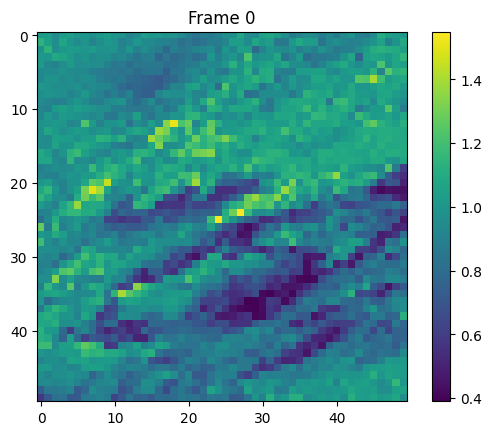

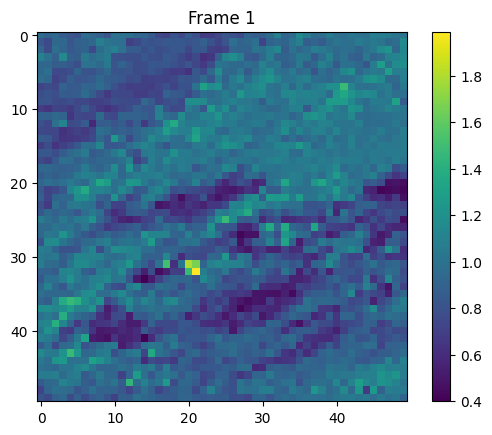

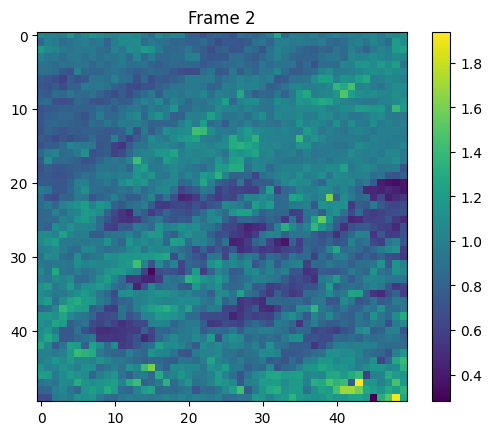

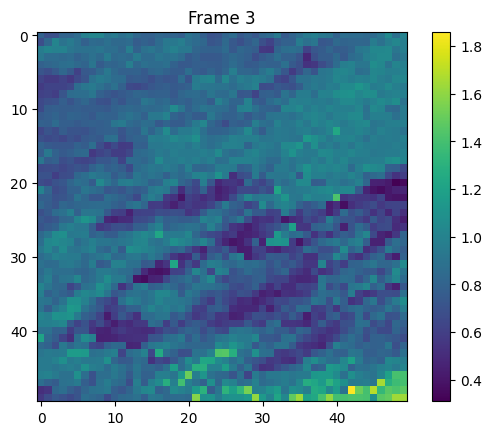

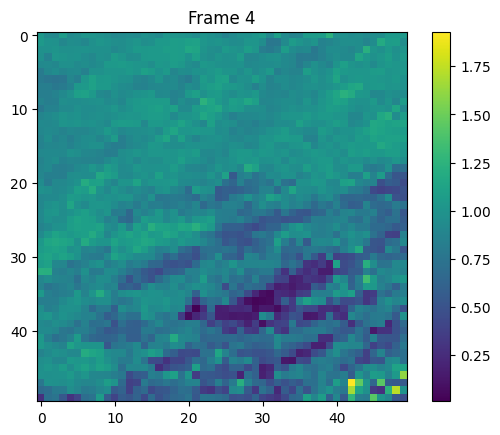

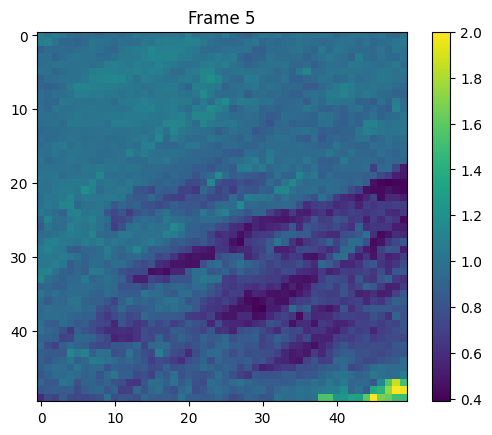

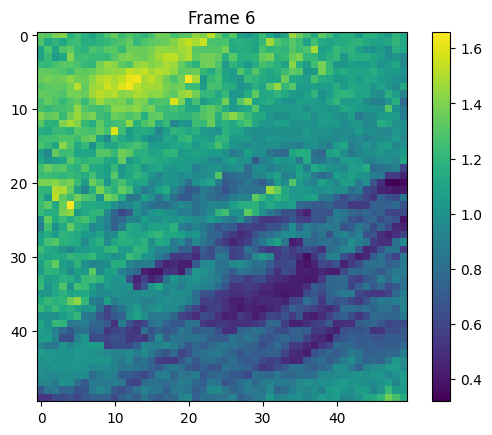

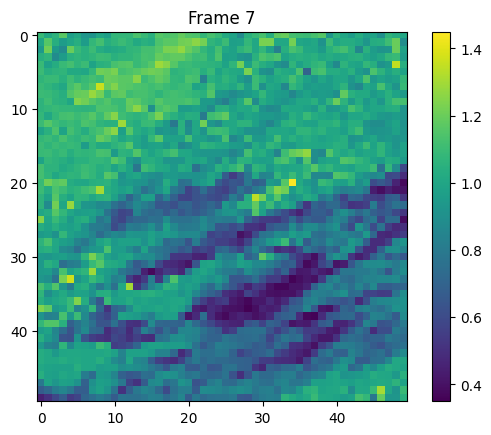

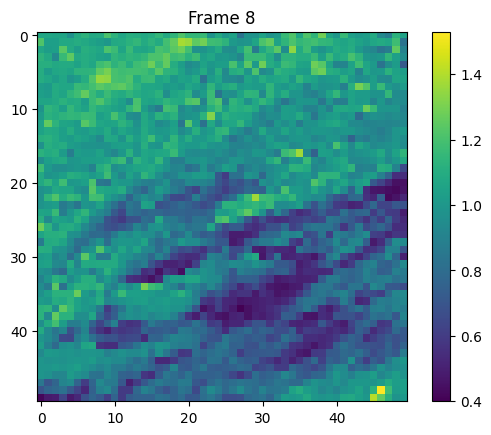

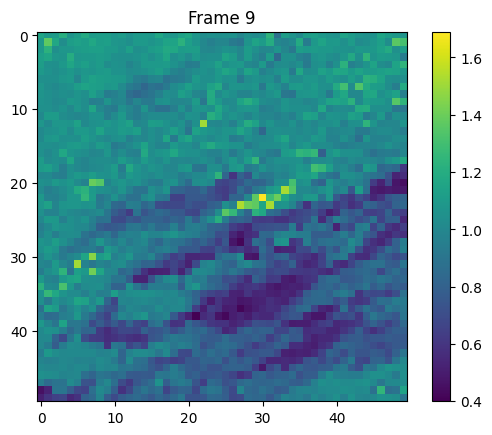

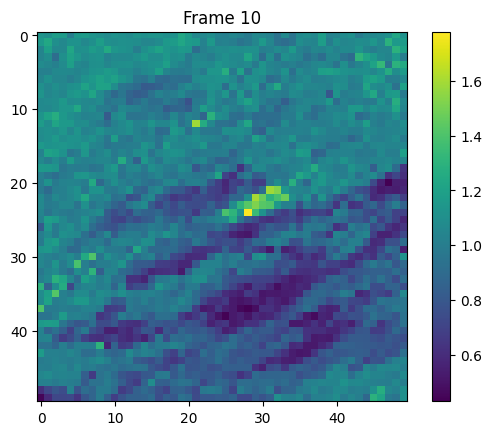

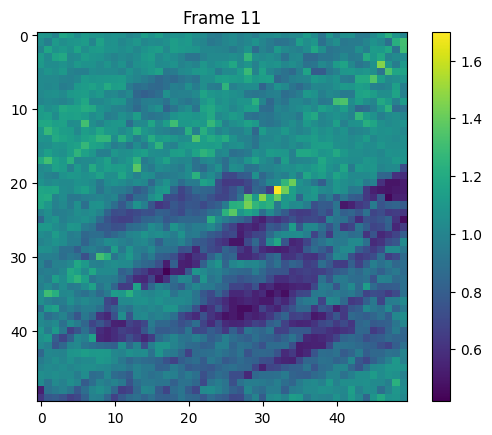

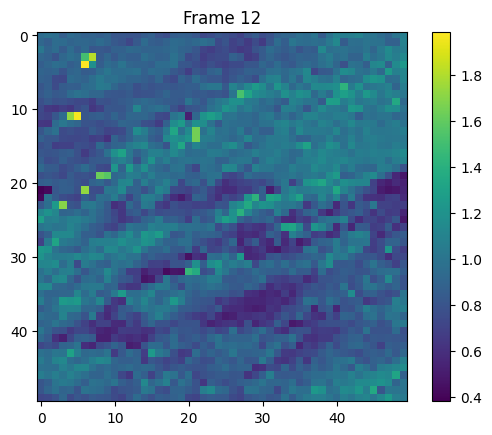

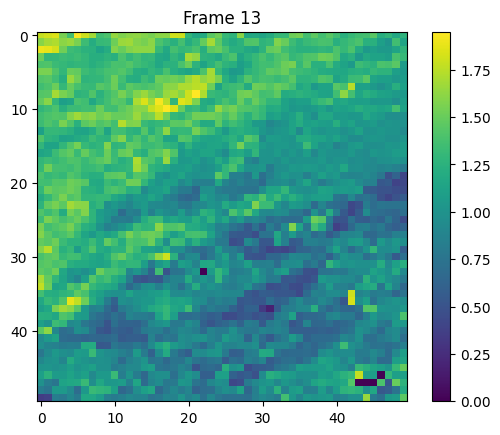

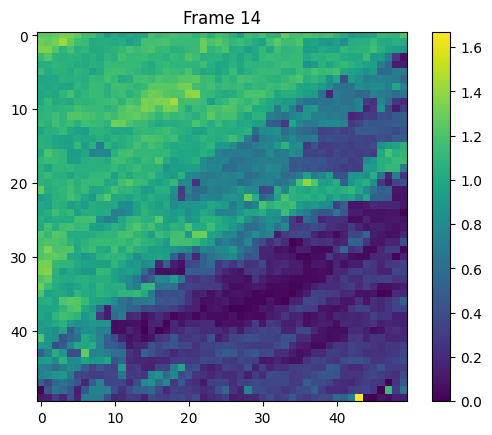

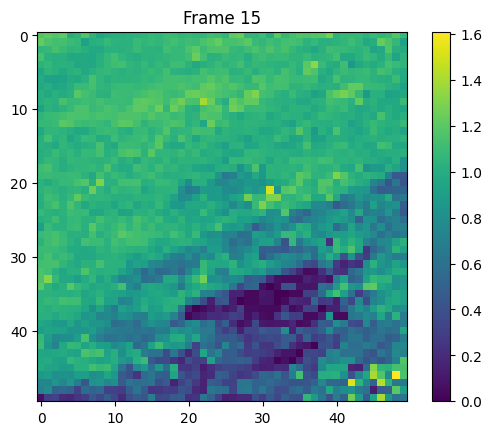

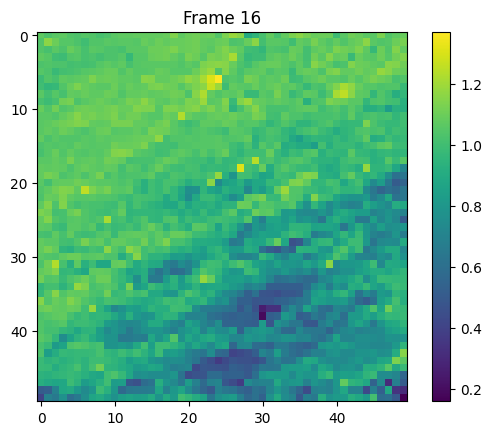

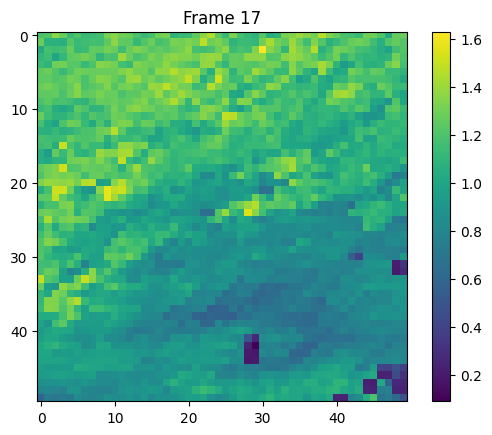

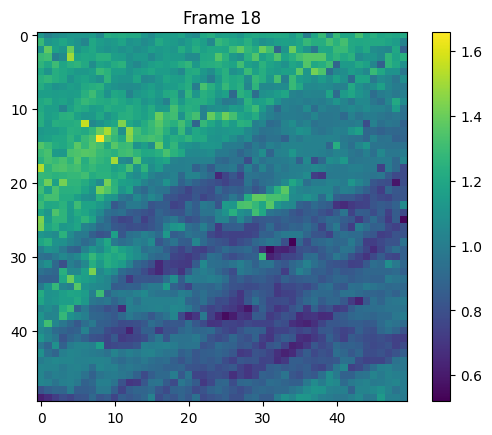

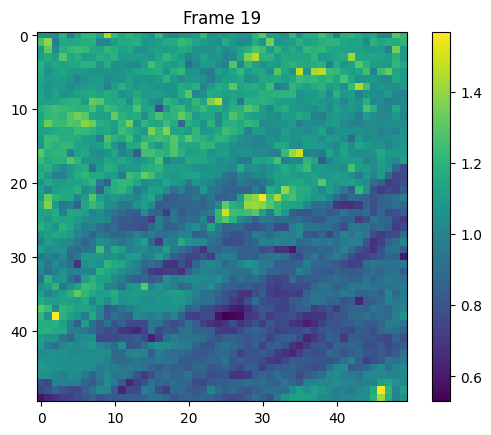

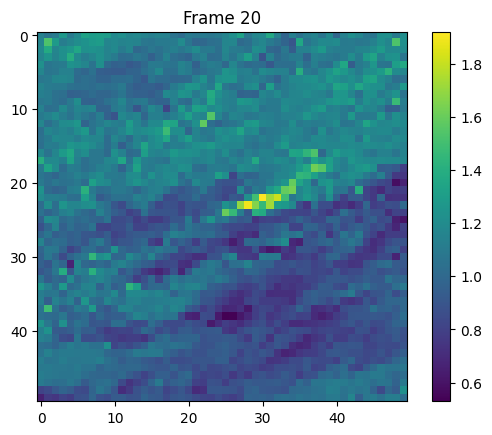

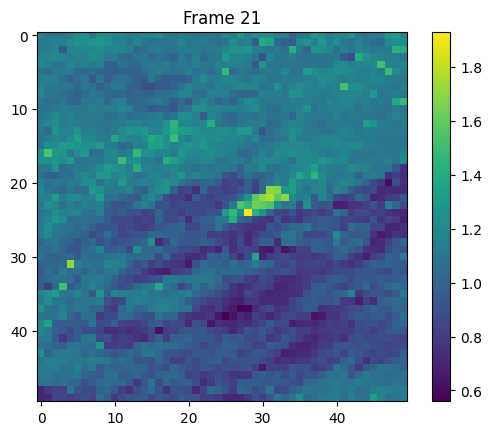

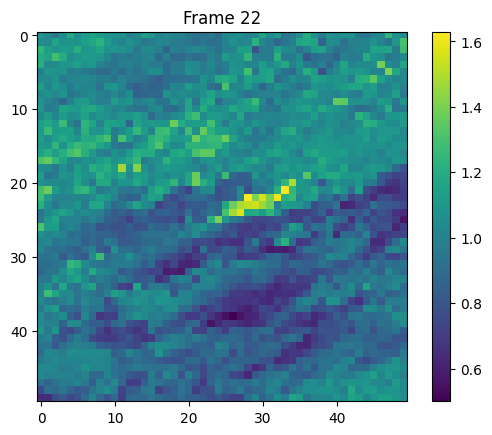

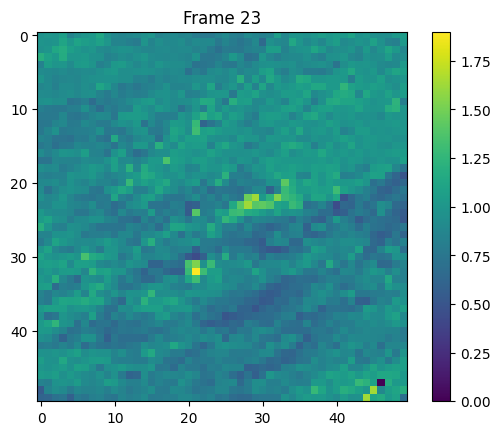

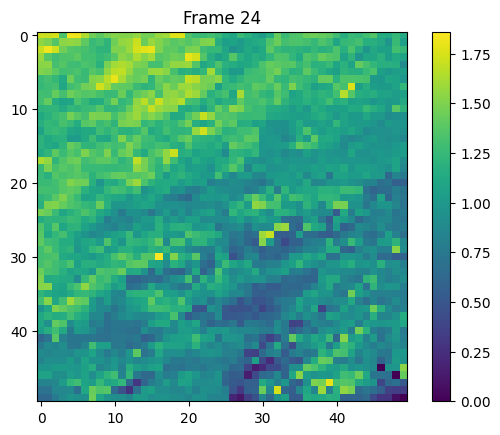

In [200]:
n = np.random.choice(range(len(data)), size=1)[0]
example = data[n]
print(example.shape)
print(file_list[n])

(times, length, width, channel) = example.shape
res = np.zeros(shape=example.shape)
for i in range(times):
    for x in range(length):
        for y in range(width):
            if example[i, x, y, 0] >= 2:
                print("BAD VALUE TO BE REPLACED:", example[i, x, y, 0])
                samples = 0
                new = 0
                for j in range(max(0, i-2), min(times, i+1)):
                    samples += 1
                    print("SAMPLE:", example[j, x, y, 0])
                    new += example[j, x, y, 0]
                    
                print("REPLACEMENT VALUE:", round(new/samples, 2))
                res[i, x, y, 0] = round(new/samples, 2)
            else:
                res[i, x, y, 0] = example[i, x, y, 0]

for it in range(len(res)):
    plt.imshow(res[it, :, :, 0])
    plt.title("Frame " + str(it))
    plt.colorbar()
    plt.show()

# for i in range(5):
#     for idx, ax in enumerate(axes[i]):
#         arr = example[idx+5*i, :, :, 1]
#         ax.imshow(arr)
#         ax.set_title(f"Frame {idx + 1 + 5*i}")
#         ax.axis("off")
        


SAMPLE: /home/fun/wildfire_data/July_Complex_2020-07-24
(15, 20, 20, 5) (10, 20, 20, 5)
1/1 [==============================] - 0s 59ms/step


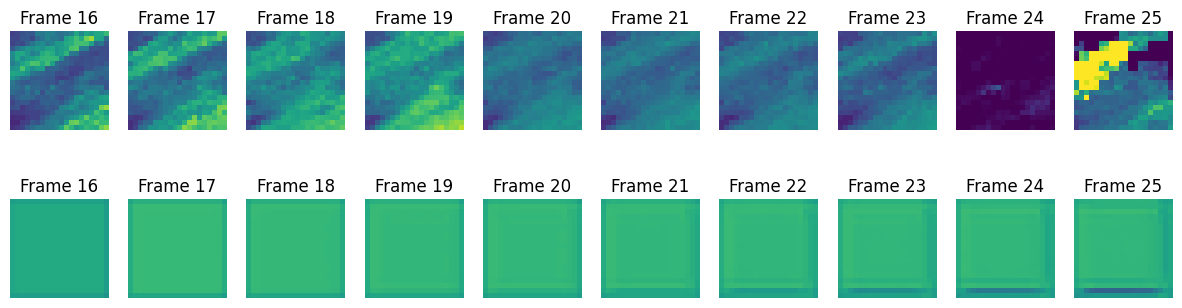

In [71]:
n = np.random.choice(range(len(data)), size=1)[0]
print("SAMPLE:", file_list[n])

example = data[n]
sample = example[:15, :, :, :]
actual = example[15:, :, :, :]

print(sample.shape, actual.shape)

for i in range(10):
    new_prediction = model.predict(np.expand_dims(sample, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    remaining_feats = actual[i, :, :, 1:]
    remaining_feats = remaining_feats[np.newaxis, ...]
    full_frame = np.concatenate((predicted_frame, remaining_feats), axis=3)
    
    sample = np.concatenate((sample, full_frame), axis=0)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(actual[idx, :, :, 0]), vmin=0, vmax=2)
    ax.set_title(f"Frame {idx + 16}")
    ax.axis("off")

new_frames = sample[15:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_prediction[idx, :, :, 0]), vmin=0, vmax=1)
    ax.set_title(f"Frame {idx + 16}")
    ax.axis("off")

plt.show()

In [204]:
sample = sample[np.newaxis, ...]
out = model(sample)

(1, 15, 50, 50, 1)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


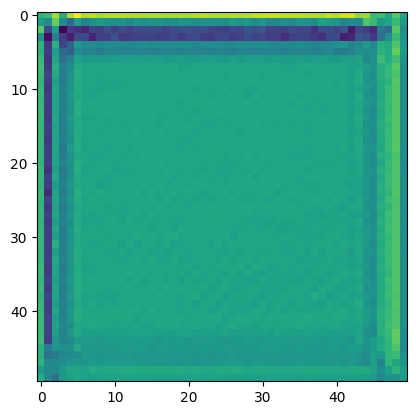

In [208]:
print(out.shape)
for it in range(15):
    arr = out[:, it, :, :, :]
    arr = np.reshape(arr, (50, 50))
    plt.imshow(arr)